In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Example: Unzip into the current working directory - since i have a zip in my drive and i want to unzip into my colab env for faster access
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 31.2 MB/s eta 0:00:00


In [ ]:
# Standard Library Imports
import os
import random
import shutil
import warnings
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
# Image Processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import rasterio
from PIL import Image
import PIL
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import AdamW
import keras_cv
keras.mixed_precision.set_global_policy("mixed_float16")
# Progress Bars
import tqdm
from tqdm.auto import trange, tqdm
# Evaluation Metrics
import sklearn
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend


In [ ]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
COLOR_MODE = "rgb"
SHUFFLE = True
TRAIN_PATH = "/content/dataset/"
SEED = 4224
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 4
NUM_EPOCHS = 50
INITIAL_LEARNING_RATE = 0.0001

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
def load_batches(imgsz: tuple, bsz: int, clr: str, shuffle: bool, path_: str, seed: int):
    try:
        batch_1, batch_2 = image_dataset_from_directory(
            image_size=imgsz,
            directory=path_,
            color_mode=clr,
            shuffle=shuffle,
            validation_split=0.2,
            subset="both",
            seed=seed,
            labels="inferred",
            batch_size=bsz,
            class_names=None,
            interpolation="bilinear",
            crop_to_aspect_ratio=True
        )
        return batch_1, batch_2
    except ValueError as e:
        print(f"Error loading data from directory {path_}: {str(e)}")
        return None, None

train_batch, valid_batch = load_batches(imgsz=IMAGE_SIZE, bsz=BATCH_SIZE, clr=COLOR_MODE, shuffle=SHUFFLE, path_=TRAIN_PATH, seed=SEED)
if train_batch is None:
    print("Failed to load training batch. Check directory and file formats.")


Found 11240 files belonging to 4 classes.
Using 8992 files for training.
Using 2248 files for validation.


In [ ]:
train_batch.class_names

['cocci', 'healthy', 'ncd', 'salmo']

In [ ]:
def rescale_imgs(img_, lbl_):
    img_ = tf.cast(img_, tf.float32)
    return img_/255.0, lbl_

train_batch = train_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)
valid_batch = valid_batch.map(rescale_imgs, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
def augment_img(img_, lbl_):
    image = tf.image.random_flip_left_right(img_)
    image = tf.image.central_crop(image, 0.85)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    return tf.cast(image, tf.float32), lbl_

train_batch = train_batch.map(augment_img, tf.data.AUTOTUNE)
train_batch = train_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_batch = valid_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
len(valid_batch) * 32

2272

In [ ]:
def val_batch_class_distribution(valid_batch):
    images = list()
    labels = list()

    for img, lbl in valid_batch.unbatch():
        images.append(img)
        if lbl == 0:
            labels.append("Coccidiosis")
        elif lbl == 1:
            labels.append("Healthy")
        elif lbl == 2:
            labels.append("Newcastle Disease")
        else:
            labels.append("Salmo")
    images = np.array(images)
    labels = np.array(labels)

    print(f'Coccidiosis Percentage: {np.mean(labels == "Coccidiosis")}')
    print(f'Healthy Percentage: {np.mean(labels == "Healthy")}')
    print(f'Newcastle Disease Percentage: {np.mean(labels == "Newcastle Disease")}')
    print(f'Salmo Percentage: {np.mean(labels == "Salmo")}')
    return labels

labels_ = val_batch_class_distribution(valid_batch)

Coccidiosis Percentage: 0.2611209964412811
Healthy Percentage: 0.24332740213523132
Newcastle Disease Percentage: 0.2557829181494662
Salmo Percentage: 0.23976868327402134


In [ ]:
weights_ = class_weight.compute_class_weight("balanced", classes = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], y = [i.lower() for i in labels_])
weight_dict = {}
for i, j in enumerate(weights_):
    weight_dict[i] = j
weight_dict

{0: 0.9574105621805792,
 1: 1.0274223034734917,
 2: 0.9773913043478261,
 3: 1.0426716141001855}

In [ ]:
def create_nasnetmobile_model():
    # backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    #     "efficientnetv2_b2_imagenet",
    #     activation="relu",
    #     input_shape=(224, 224, 3),
    #     include_rescaling = False,
    #     load_weights = True
    # )
    # # TODO: Comment the below line if performing bad.
    # # backbone.trainable = False

    # model = keras_cv.models.ImageClassifier(
    #     backbone=backbone,
    #     num_classes=NUM_CLASSES,
    #     activation = "softmax",
    #     name = "KerasCV_efficientnet"
    # )
    # # TODO: Uncomment the below line if performing bad.
    # model.trainable = True

    # initial_learning_rate = INITIAL_LEARNING_RATE
    # optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)

    # model.compile(optimizer = optimizer,
    #               loss = keras.losses.SparseCategoricalCrossentropy(),
    #               metrics = ["accuracy"])
    from keras.applications import NASNetMobile
    # from keras.applications.nasnet import preprocess_input
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.models import Model

    pre_model = NASNetMobile(input_shape=(224,224, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    # pre_model.trainable = False
    # TODO: trainable = True
    pre_model.trainable = True

    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    initial_learning_rate = INITIAL_LEARNING_RATE
    optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)
    model.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])

    return model

In [ ]:
nasnetmobile_model = create_nasnetmobile_model()

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
# keras.utils.plot_model(nasnetmobile_model, to_file = "nasnetmobile_model_architecture.png", show_shapes = True)

In [ ]:
nasnetmobile_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']        

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, accuracy_score, f1_score, recall_score

In [ ]:
def fit_model_and_save_logs(model, name:str, train_, valid_):
    # Initialize metrics list
    metrics = []

    # Extract true labels from the validation dataset
    true_values = [y for x, y in valid_.unbatch()]

    # Define callbacks
    es_cb = EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='auto',
        restore_best_weights=True
    )
    lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_best_model.h5",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    csv_log = keras.callbacks.CSVLogger(
        filename = f"{name}_logs.csv",
        separator = ","
    )

    model.fit(
        train_,
        validation_data = valid_,
        callbacks = [es_cb, lr_cb, csv_log, checkpoint_cb],
        verbose = 2,
        epochs = NUM_EPOCHS,
        # Added inverse class weight
        class_weight=weight_dict
    )

    # Convert history to a DataFrame for easier plotting
    history_df = pd.DataFrame(model.history.history)
    # Plot accuracy and loss
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6), sharey = False)
    history_df[["accuracy", "val_accuracy"]].plot(ax = ax[0], title = "Accuracy vs Validation Accuracy", lw = 2)
    history_df[["loss", "val_loss"]].plot(ax = ax[1], title = "Loss vs Validation Loss", lw = 1.7)
    plt.savefig(f"{name}_train_val.png")

    # Predict on validation data
    preds = model.predict(valid_, verbose = 2)
    preds = np.argmax(preds, axis  = 1)

    # Calculate metrics
    accuracy_ = accuracy_score(true_values, preds) * 100
    precision_ = precision_score(true_values, preds, average="weighted") * 100
    f1_ = f1_score(true_values, preds, average="weighted") * 100
    recall_ = recall_score(true_values, preds, average="weighted") * 100
    metrics.extend([accuracy_, precision_, f1_, recall_])

    # Classification report
    cr = classification_report(true_values, preds, output_dict = True)
    cr = pd.DataFrame(cr)
    cr.columns = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo', 'accuracy', 'macro avg', 'weighted avg']
    cr = cr.T
    cr.to_csv(f"{name}_classification_report.csv", index = 1)

    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ConfusionMatrixDisplay.from_predictions(true_values, preds, cmap = "Blues", display_labels = ['coccidiosis', 'healthy', 'newcastle disease', 'salmo'], ax = ax)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name}_confusion_matrix.jpg")

    metric_dataframe = pd.DataFrame(
            data = {"metrics": ["Accuracy", "Precision", "F1_Score", "Recall"],
                    "score": metrics,
                    "name": [f"{name}", f"{name}", f"{name}", f"{name}"]}
    )
    return metric_dataframe

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.81851, saving model to nasnetmobile_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 41s - loss: 0.8731 - accuracy: 0.6973 - val_loss: 0.5216 - val_accuracy: 0.8185 - lr: 1.0000e-04 - 41s/epoch - 146ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.81851 to 0.85943, saving model to nasnetmobile_best_model.h5
281/281 - 15s - loss: 0.4337 - accuracy: 0.8516 - val_loss: 0.3930 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 15s/epoch - 55ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.85943 to 0.86833, saving model to nasnetmobile_best_model.h5
281/281 - 15s - loss: 0.3514 - accuracy: 0.8801 - val_loss: 0.3532 - val_accuracy: 0.8683 - lr: 1.0000e-04 - 15s/epoch - 55ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.86833 to 0.87589, saving model to nasnetmobile_best_model.h5
281/281 - 16s - loss: 0.3127 - accuracy: 0.8939 - val_loss: 0.3323 - val_accuracy: 0.8759 - lr: 1.0000e-04 - 16s/epoch - 56ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.87589 to 0.88167, saving model to nasnetmobile_best_model.h5
281/281 - 16s - loss: 0.2866 - 

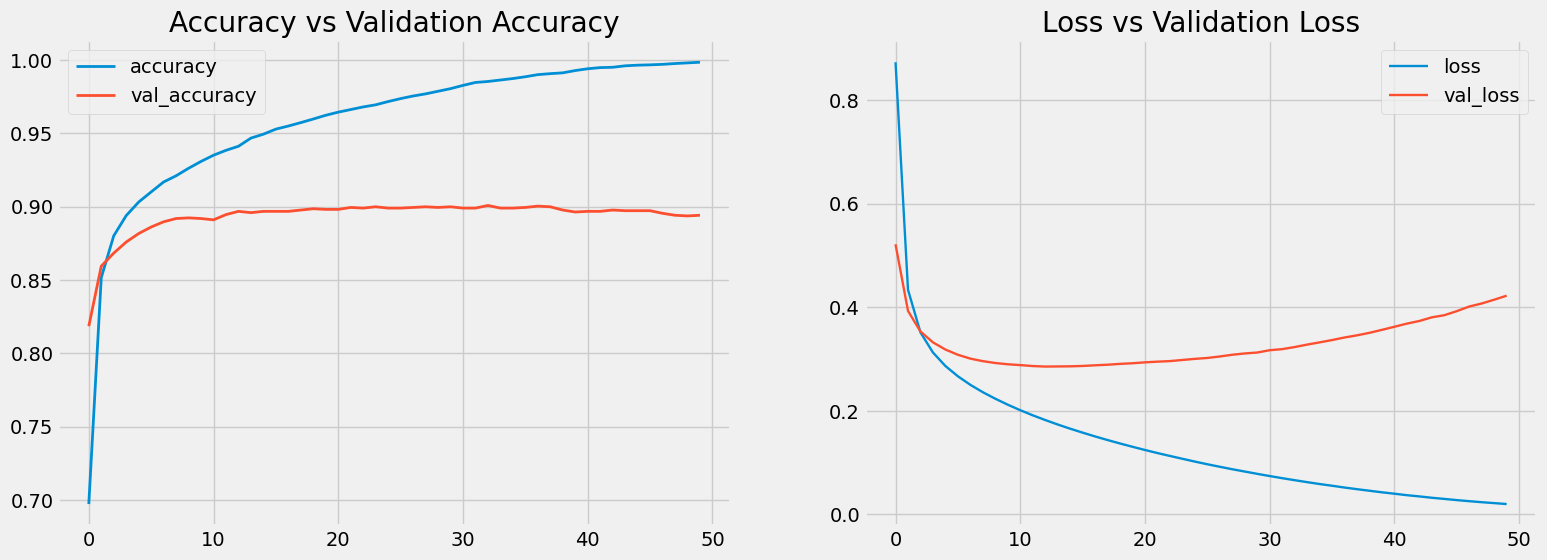

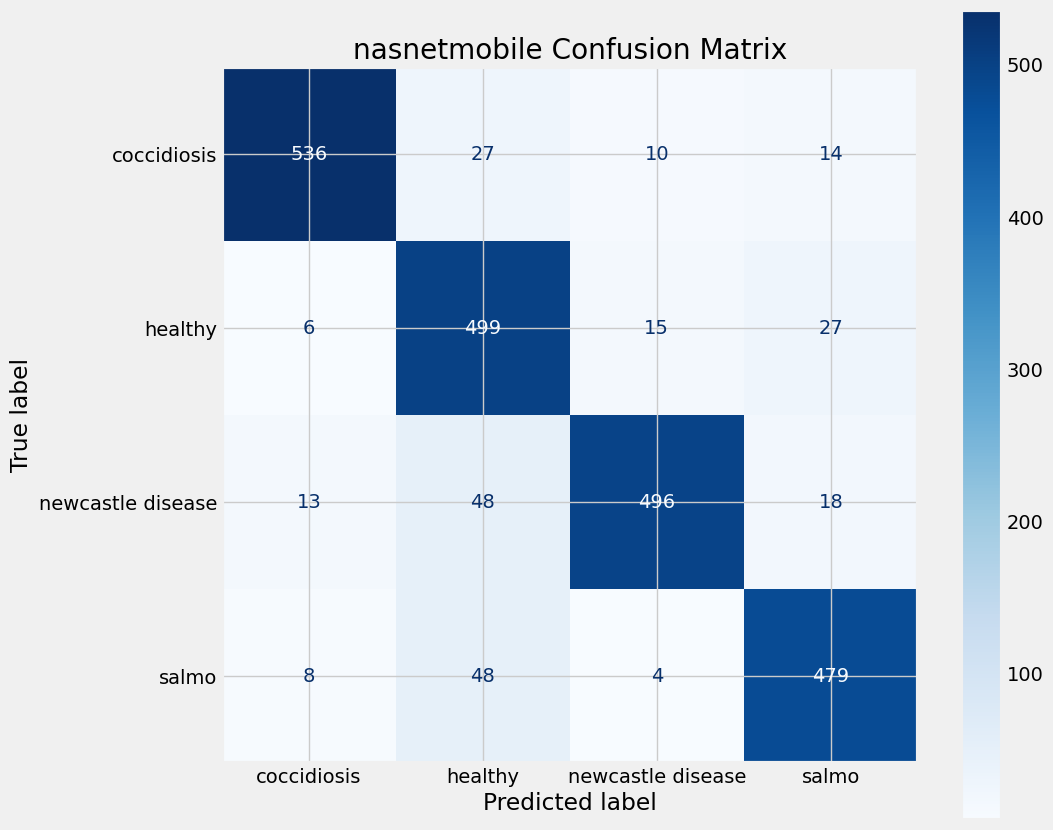

In [ ]:
# pre_model.trainable = False
# Output 1
nnm_metric_df_1 = fit_model_and_save_logs(nasnetmobile_model, "nasnetmobile", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.76246, saving model to nasnetmobile_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 234s - loss: 0.3404 - accuracy: 0.8818 - val_loss: 0.6488 - val_accuracy: 0.7625 - lr: 1.0000e-04 - 234s/epoch - 834ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.76246 to 0.80827, saving model to nasnetmobile_best_model.h5
281/281 - 66s - loss: 0.0521 - accuracy: 0.9844 - val_loss: 0.5088 - val_accuracy: 0.8083 - lr: 1.0000e-04 - 66s/epoch - 236ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.80827 to 0.86610, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.0099 - accuracy: 0.9966 - val_loss: 0.3827 - val_accuracy: 0.8661 - lr: 1.0000e-04 - 67s/epoch - 237ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.86610 to 0.89279, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.3188 - val_accuracy: 0.8928 - lr: 1.0000e-04 - 67s/epoch - 239ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.89279 to 0.90569, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.00

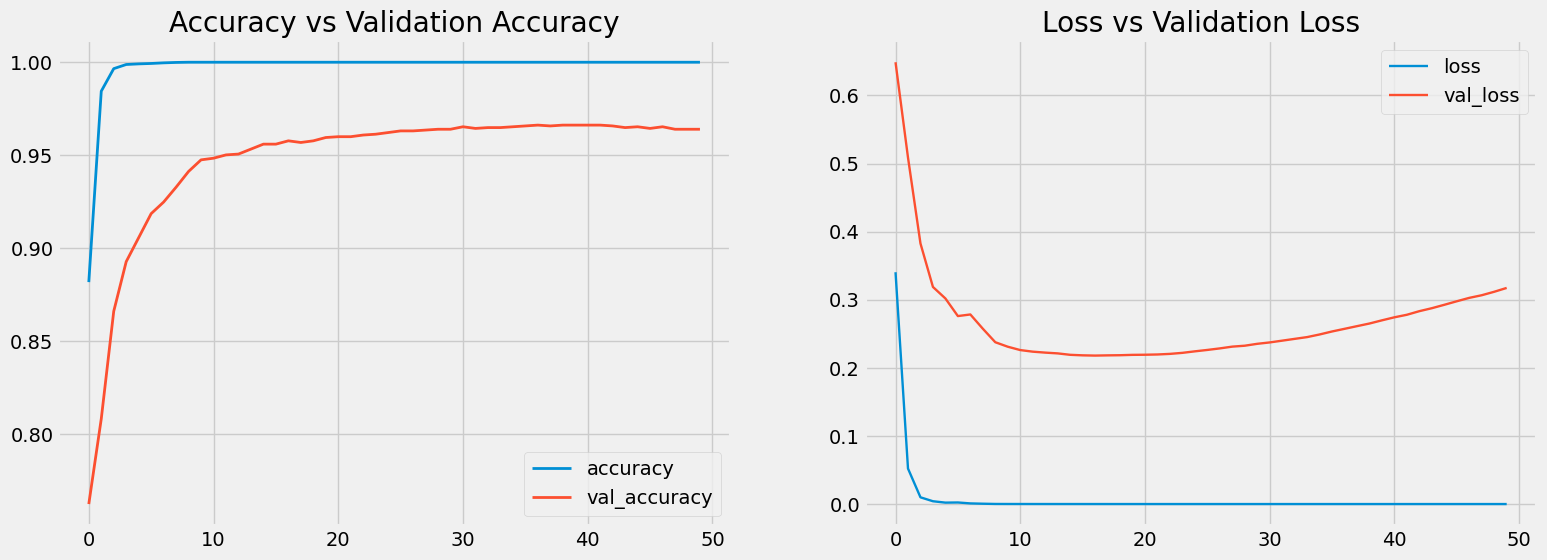

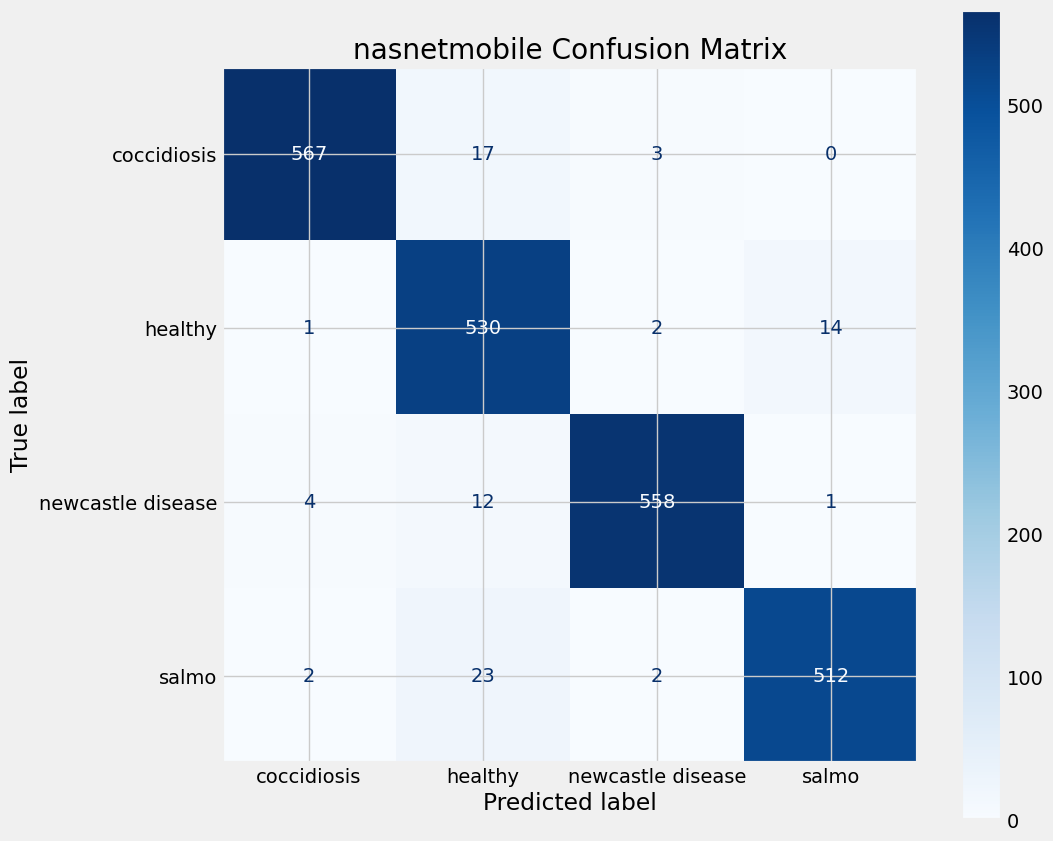

In [ ]:
# pre_model.trainable = True
# Output 2
nnm_metric_df_2 = fit_model_and_save_logs(nasnetmobile_model, "nasnetmobile", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.96752, saving model to nasnetmobile_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 231s - loss: 0.3578 - accuracy: 0.8712 - val_loss: 0.9675 - val_accuracy: 0.6886 - lr: 1.0000e-04 - 231s/epoch - 821ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.96752 to 0.64335, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.0481 - accuracy: 0.9860 - val_loss: 0.6433 - val_accuracy: 0.7963 - lr: 1.0000e-04 - 67s/epoch - 240ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.64335 to 0.52001, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.0087 - accuracy: 0.9977 - val_loss: 0.5200 - val_accuracy: 0.8403 - lr: 1.0000e-04 - 67s/epoch - 237ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.52001 to 0.47539, saving model to nasnetmobile_best_model.h5
281/281 - 67s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.4754 - val_accuracy: 0.8572 - lr: 1.0000e-04 - 67s/epoch - 239ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.47539 to 0.41324, saving model to nasnetmobile_best_model.h5
281/281 - 66s - loss: 0.0012 - accuracy: 0

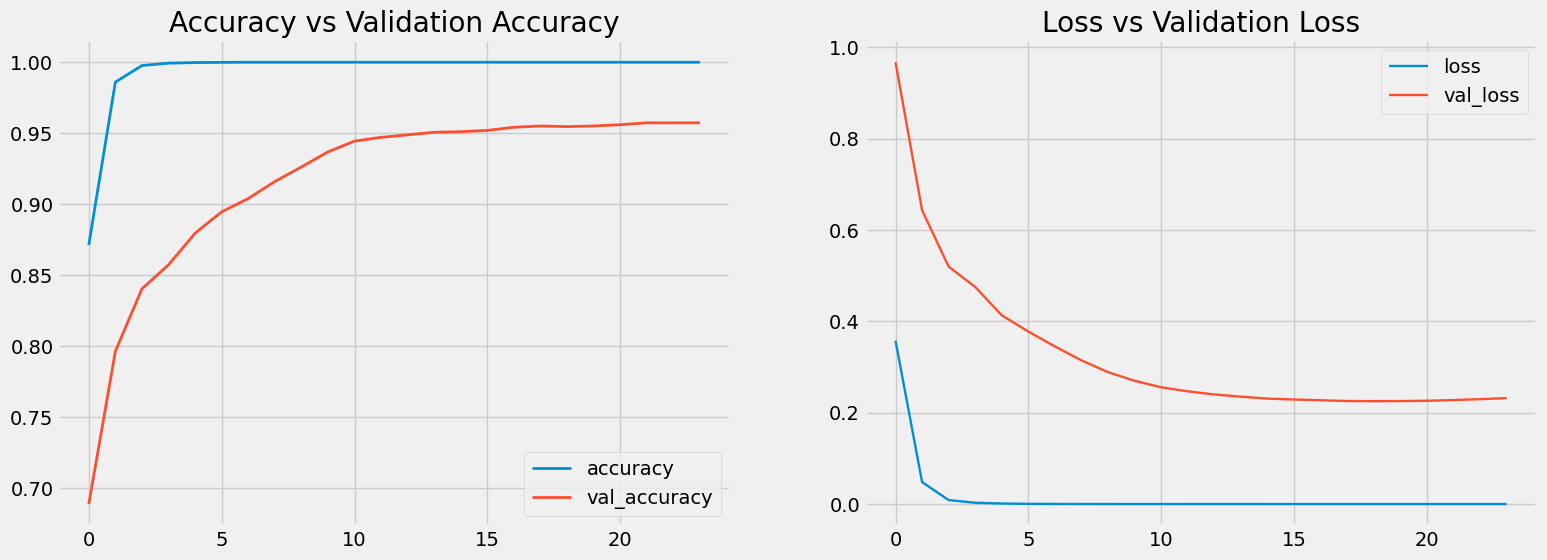

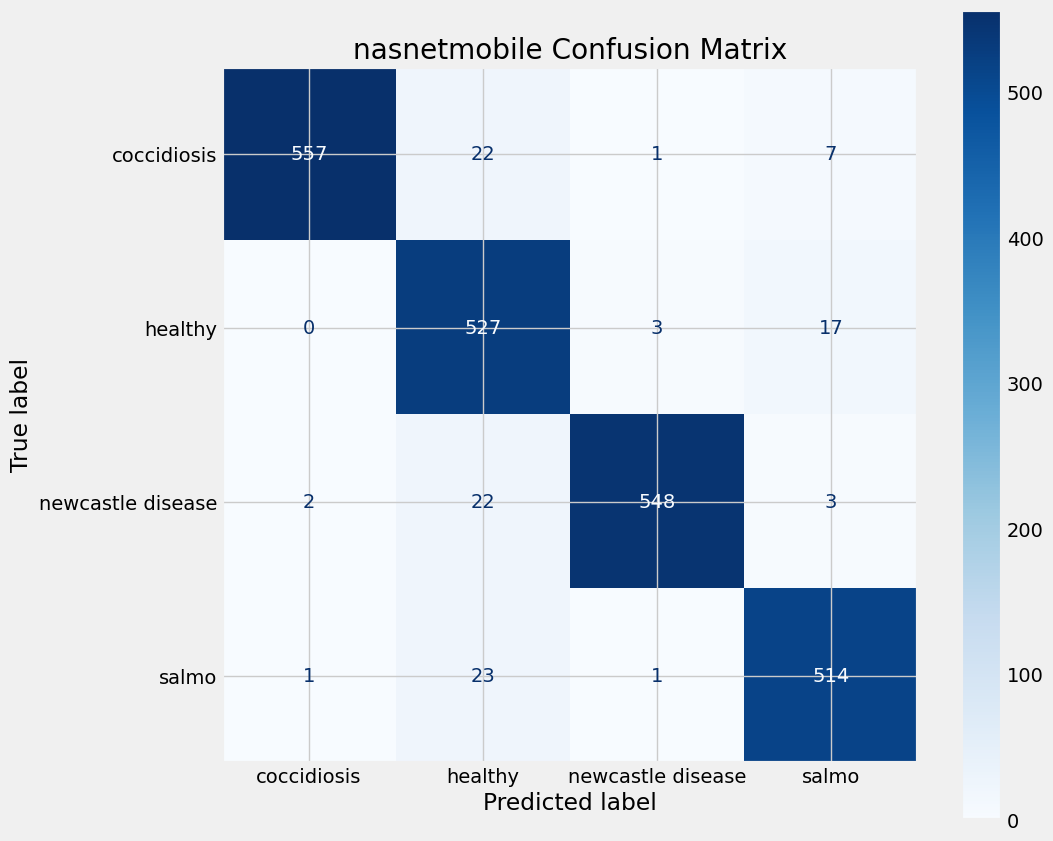

In [ ]:
# pre_model.trainable = True
# EarlyStopping and ModelCheckpoint => monitor = val_loss
# ReduceLROnPlateau => patience = 3
# Output 3
nnm_metric_df_3 = fit_model_and_save_logs(nasnetmobile_model, "nasnetmobile", train_batch, valid_batch)

In [ ]:
mkdir output

In [ ]:
cp -r './output' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/6_NasNetMobile/3_output_50_monitor_val_loss'

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import keras_cv

# # Define the custom objects
custom_objects = {
    'AdamW': AdamW
}

# Load the saved model with custom objects
model = load_model('nasnetmobile_best_model.h5',
                   custom_objects=custom_objects
                   )


In [ ]:
# Load and preprocess the sample image
image_class = 'salmo'
img_path = f'./dataset/{image_class}/{image_class}.99.jpg'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if your model expects normalized images

# Make a prediction
predictions = model.predict(img_array)

# Interpret the prediction (this depends on your model's output format)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 42ms/step
Predicted class: [3]
